# Demand-Side Optimisation 
Written by Max Bloor as part of Imperial College London's EURECHA Student Contest Submission


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.optimize import minimize

## Greek Renewable Energy Data

In [3]:
#Read production and weather data
production_data = pd.read_csv(r'\Users\mfb22\Documents\GitHub\RenewableEnergyGR\time_series_60min_singleindex.csv',parse_dates=[0])
weather_data = pd.read_csv(r'\Users\mfb22\Documents\GitHub\RenewableEnergyGR\weather_data_GR_2018_19.csv',parse_dates=[0])

In [4]:
production_data_18 = production_data[production_data['utc_timestamp'].dt.strftime('%Y') == '2018']
production_data_19 = production_data[production_data['utc_timestamp'].dt.strftime('%Y') == '2019']

### Wind Data

Text(0, 0.5, 'Power [MW]')

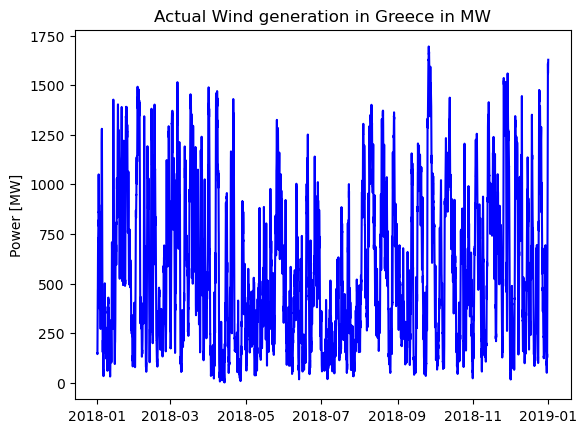

In [5]:
#Wind Generation
plt.plot(production_data_18['utc_timestamp'], production_data_18['GR_wind_onshore_generation_actual'], c='blue')
plt.title('Actual Wind generation in Greece in MW')
plt.ylabel('Power [MW]')


### Solar Data

Text(0, 0.5, 'Power [MW] ')

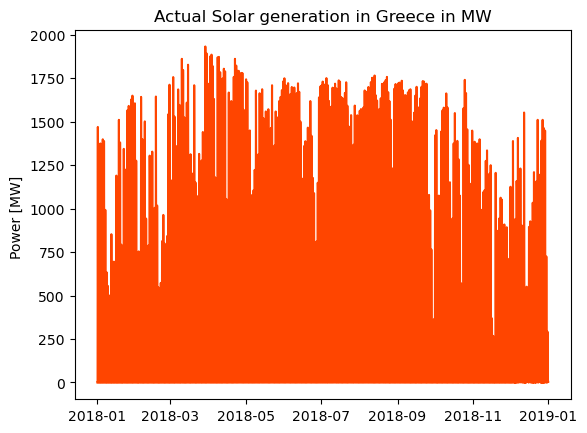

In [6]:
plt.plot(production_data_18['utc_timestamp'], production_data_18['GR_solar_generation_actual'], c='OrangeRed')
plt.title('Actual Solar generation in Greece in MW')
plt.ylabel('Power [MW] ')

<function matplotlib.pyplot.show(close=None, block=None)>

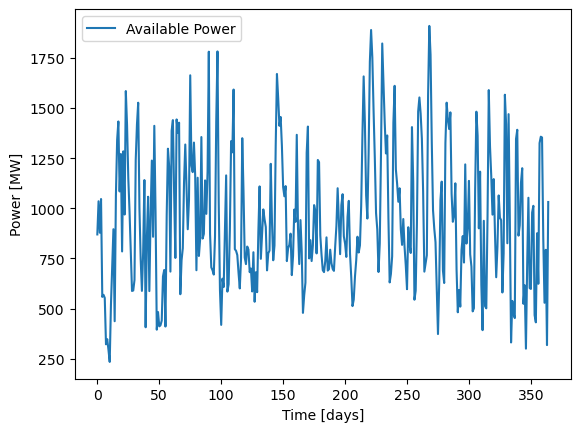

In [16]:
ts = 365
nrows = int(8760/365) #take average every n-rows
solar = groupedAvg(production_data_18['GR_solar_generation_actual'].fillna(0).to_numpy(),nrows)
wind = groupedAvg(production_data_18['GR_wind_onshore_generation_actual'].fillna(0).to_numpy(),nrows)
p_total = np.zeros(ts)
for i in range(ts):
    p_total[i] = solar[i]+wind[i]
t = np.arange(ts)

plt.plot(t,p_total,label = 'Available Power')
plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Power [MW]')
plt.show

## Demand-Side Optimisation (Data-Driven)

In [249]:
def model(x,ts): 
    '''
    Optimisation Model 
    Decision variables: Power to each plant, Tank (CO2 and MeOH) Volume, and area of electrodes.
    '''
    #Unwrap input variables
    P = np.zeros((2,ts))
    P[0,:] = x[0:ts] #Power to CO2 plant
    P[1,:] = x[ts:2*ts] #Power to MeOH plant
    V = x[ts*2:ts*2+2] #Volume of CO2 and MeOH tanks
    A = x[ts*2+2] #Area of electrodes
    electrode_price = 919.7
    
    #Flowrate of CO2/Methanol from a given power input
    f = np.zeros((2,ts))
   
    for i in range(2):
        for t in range(ts):
            f[i,t] = PM(P[i,t],A,i)
    
    #Objective Function (0 - CO2, 1 - Electrolyzer)
    opex = 0
    for ti in range(ts):
        opex += (E_co2(f[0,ti])+E_elec(P[1,ti],A))

    CAPEX_elec = (A * electrode_price + 18536715.16 ) * (813/603.1)
    r,n = 0.1,15 # Discount rate, lifetime
    AnnCost_elec = (r / (1 - (1+r)**(-n)) * CAPEX_elec) #w/o opex
    obj = opex + C_co2(V[0]) + C_elec(V[1]) + AnnCost_elec
   
    return obj
    

In [251]:
def electrolyzer2 (I_total,A):
  '''
  Electrolyzer modelling
  Be advice that constraint should be imposed outside this function: A_max >= I_total/J where J = 0.3
  Input: A scalar of electric current (I_total) and a scalar of electrode area (A)
  Output: Two rank-1 (1D) arrays for inlet and outlet molar flow rate, and a scalar of (OPEX + Annualised_CAPEX)
  '''

  # Empty matrix for components mass balance
  comp = 6 # [CO2, H2O, CH3OH, CH4, H2, O2]
  rx = 4 # [CH3OH evolution, CH4 evolution, H2 evolution, O2 evolution]
  IN = np.zeros(comp) # Inlet
  OUT = np.zeros(comp) # Outlet

  # Input nu
  nu=[] # Stoichiometry
  nu += [[-1,1,1,0,0,0]] # R1
  nu += [[-1,2,0,1,0,0]] # R2
  nu += [[0,0,0,0,1,0]] # R3
  nu += [[0,-2,0,0,0,1]] # R4
  nu = np.array(nu)

  # Model parameters and assumptions
  F = 96485 # Faraday constant
  S = 0.66 # Selectivity assumption
  X = 0.2 # Conversion assumption
  eF = 0.1 # Faradaic efficiency for HER
  J = 0.3 # [A / sq-cm], current density
  V = 2 # [volt], potential
  electrode_price = 919.7 # [USD / sq-m]
  electricity_price = 0.03 # [USD / kWh]
  t = 24 # Operating time
  x_MeOH = 3.97572040199699e-002 # Methanol outlet concentration from Hysys to have a 10% -vol MeOH

  # Solve for the reaction extent
  E = np.zeros(rx) # Reaction extent
  E[0] = ((1-eF) * I_total)/(6*F + (1-S)/S * 8*F) # R1
  E[1] = (1-S)/S * E[0] # R2
  E[2] = (eF * I_total)/(2*F) # R3
  E[3] = (I_total)/(4*F) # R4

  # Calculate inlet requirement

  # Solve consumption
  E = E.reshape((1,rx))
  cons = nu.T*E # Consumption of each components in EACH reaction
  Cons = np.sum(cons,axis=1) # Consumption of each components in ALL reaction

  # Solve mass balance
  IN[0] = (E[0,0] + E[0,1])/X
  OUT = IN + Cons
  OUT[1] = OUT[0] / x_MeOH # 10% volume fraction of MeOH at outlet, calculating the required 
  IN[1] = OUT[1] - Cons[1] # Required water inlet to achieve 10% volume fraction of MeOH at outlet 

  # Solve current
  e = np.array([6,8,2,4])
  I = (e*F*E).reshape(rx) # Current for each reaction

  # Sizing
  #A = I_total / J * 1E-4 # [sq-m] => This must be imposed outside this function: A_max >= I_total/J

  # Costing
  CAPEX = (A * electrode_price + 18536715.16 ) * (813/603.1) # 2022 [USD] inc. knockout drum
  
  OPEX = V * I_total * t * electricity_price # [USD / year]
  r,n = 0.1,15 # Discount rate, lifetime
  AnnCost = (r / (1 - (1+r)**(-n)) * CAPEX) #w/o opex
  
  return IN, OUT,OPEX, AnnCost


In [199]:
#Power-Flowrate model
def PM(P,A,i):
    '''
    Convert Power [MW] to flowrate [m3] for both plants
    '''
    if i == 0:
        f_co2 =(1/6.57)*P*1/1.784 #Energy demand of DAC: 6.57 MJ/kg, density: 1.784 kg/m3
        return f_co2
    else:
        I = (P*10**6)/2 #Assuming 2V supply to electrolyzer
        In,out,opex,AnnCost = electrolyzer2(I,A)
        f_elec = out[2]*32/1000*1/791.4
        return f_elec 

In [200]:
def flow_out_co2(P_elec,A,ts):
    '''
    Calculate flowrate [m3] out of CO2 Tank
    '''
    flow_in = np.zeros(ts)
    for i in range(ts):
        I = (P_elec[i]*10**6)/2 #Assuming 2V supply to electrolyzer
        In,f_elec,opex,AnnCost = electrolyzer2(I,A)
        flow_in[i] = In[0] #molar flowrate
        flow_in[i] = flow_in[i]*(44*(10**-3)/1.784) #Volumetric flowrate
    return flow_in

In [201]:
def PM_constraint(P,A,i,ts):
    '''
    Construct an array of shape (ts,) to store flowrate for use in optimiser constraints
    '''
    f = np.zeros(ts)
    for t in range(ts):
        f[t] = PM(P[t],A,i)
    return f

In [202]:
def flow_constraint(f):
    '''
    Check if any flowrate is negative (non-physical)
    '''
    if np.any(f < 0):
        return -1
    else:
        return 1

In [203]:
def P_tot_Constraint(P_co2,P_Elec,ts,prod_rate):
    '''
    Check if the power drawn by the two plants is less than or equal to the available power
    '''
    P_bal = np.zeros(ts)
    for ti in range(ts):
        P_bal[ti] = p_tot(ti,ts) - (P_co2[ti]+P_Elec[ti]+(0.4931+6.684e-5)*(prod_rate/1.83))
    if np.any(P_bal < 0):
        return -1
    else:
        return 1

In [204]:
def TM(fin,fout,V):
    '''
    Tank Level Model
    
    fin - flowrate into tank_i [m3/hr]
    fout - flowrate out of tank_i [m3/hr]
    V - Total volume of tank_i [m3] (assumed cyclindrical with L/r = 4)
    '''
    #Height to radius ratio
    L_R = 4
    
    # Volume of liquid within the tank
    V_l = sum(fin - fout) 
    
    # Radius of tank
    r_T = (V/(L_R*3.14))**(1/3)
    
    #Level in the tank
    Level = V_l/(3.14*r_T**2)
    
    return Level

In [205]:
def TM_Con(fin,fout,V,time_steps):
    '''
    Tank max/min level constraint:
    Enforce the level in the MeOH tank
    remains within 10-90% of max level
    '''
    #Construct Variables
    L = np.zeros(time_steps)
    LoverH = np.zeros(time_steps)   
    #Height to radius ratio
    L_R = 4
    #Tank radius
   
    r_T = (V/(L_R*3.14))**(1/3)
    
    #Tank height
    H = r_T*L_R
    
    for i in range(time_steps):
        L[i] = TM(fin[:i+1],fout,V)
        LoverH[i] = L[i]/H

    
    if np.any(L/H > 0.9):
        return -1
    elif np.any(L/H < 0):
        return -1
    else:
        return 1

In [206]:
def RM(fin,fout,V):
    '''
    CO2 Receiver Pressure Model
    
    fin - flowrate into tank_i [m3/time_step]
    fout - flowrate out of tank_i [m3/time_step]
    V - Total volume of tank_i [m3]
    Return Pressure [bar]
    CO2 receiver pressure limit in practice: 6.2 bar to 9.6 bar
    '''
    #Convert input flowrates from volumetric flow to molar flow 
    fin = fin*1.784*1000/44 #rho_CO2[kg/m3] *1/M [mol/kg]

    fout = fout*1.784*1000/44 #rho_CO2[kg/m3] *1/M [mol/kg]
    
    # Moles of CO2 within the tank, up to the current ts
    N = sum(fin - fout) 
    
    # Calculate the pressure using PV=nRT
    Pressure = N * 8.314 * 298.15 / V
    Pressure = Pressure / 10**5 #Convert from Pa to Barg
    return Pressure

In [207]:
def RM_Con(fin,fout,V,time_steps):
    '''
    CO2 receiver max/min pressure constraint:
    Enforce that the pressure within the CO2 receiver
    remains within 6.2-9.2 bar
    '''
    P = np.zeros(time_steps)
    
    for i in range(time_steps):
        P[i] = RM(fin[:i+1],fout[:i+1],V)
   
    if np.any(P > 9.2):
        return -1
    elif np.any(P < 0): 
        return -1
    else:
        return 1

In [208]:
def E_co2(f):
    '''
    CO2 plant operating cost model from literature review
    '''
    OPEX = 600*f*1.784/1000
    return OPEX

In [209]:
def E_elec(P,A):
    '''
    Electrolyzer plant opex model
    '''
    I = P/2 #Assuming 2V supply to electrolyzer
    In,f_elec,OPEX,AnnCost = electrolyzer2(I,A)
    return OPEX

In [210]:
def C_electrolyzer(P):
    '''
    Electrolyzer plant opex model
    '''
    I = P/2 #Assuming 2V supply to electrolyzer
    In,f_elec,OPEX,AnnCost = electrolyzer2(I,A)
    return AnnCost

In [211]:
def C_co2(V):
    '''
    CO2 Receiver CAPEX correlation from Sinnott
    Input: V [m3]
    Assumed cyclindrical with height(L):diameter(D) = 4
    Return capital cost (2022) [USD]
    '''
    # Vessel dimension
    L_D = 4
    D = ( V/(0.25*3.14*L_D) )**(1/3)
    L = L_D * D

    # Calculation of vessel shell mass
    metal_density = 8000 # kg/cu-m, from Sinnott for SS304L
    t = 0.02 # 20 mm. from Sinnott for a vessel operating at 140 psi (max) SS304L
    metal_mass = 3.14 * D * L * t * metal_density # in kg, from Sinnott

    # Costing correlation from Table 6.6 Sinnott
    a = 15000
    b = 68
    n = 0.85
    C = a + b * (metal_mass)**n

    # CEPCI: bring cost from 2007 to 2022
    C = C * (813/508.7)

    # Annualisation
    r,n = 0.1,15 # Discount rate, lifetime
    C = r / (1 - (1+r)**(-n)) * C
    return C

In [212]:
def C_elec(V):
    '''
    Cone Roof Tank CAPEX correlation from Sinnott
    Input: V[m3]
    '''
    # Costing correlation from Table 6.6 Sinnott
    a = 5000
    b = 1400
    n = 0.7
    
    #Sinnott CAPEX Correlation * CEPCI ratio
    C = (a + b*V**n) * (813/508.7) 
    
    # Annualisation
    r,n = 0.1,15 # Discount rate, lifetime
    C = r / (1 - (1+r)**(-n)) * C
    return C

In [8]:
def groupedAvg(Arr, N):
    '''
    Average every N-rows of input array (Arr). Used for optimising over different number of time steps.
    '''
    result = np.cumsum(Arr, 0)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

In [214]:
def p_tot(ti,ts):
  '''
  Average and total the solar and wind generation in Greece from each time step
  '''
  nrows = int(8760/ts) #take average every n-rows
  solar = groupedAvg(production_data_18['GR_solar_generation_actual'].fillna(0).to_numpy(),nrows)
  wind = groupedAvg(production_data_18['GR_wind_onshore_generation_actual'].fillna(0).to_numpy(),nrows)
    
  p_tot = solar[ti]+wind[ti] 
  return p_tot

In [215]:
def A_Constraint(P,A,ts):
    '''
    Enforce electrode area constraint
    '''
    bal = np.zeros(ts)
    for i in range(ts):
        bal[i] = (P[i]/(2*0.3)) - A
    if np.any(bal < 0):
        return -1
    else:
        return 1

In [237]:
def random_start(f,time_steps,iterations,prod_rate):
    '''
    Stochastic search algorithm to find good initial point for optimiser.
    '''
    #Construct variables
    cons_check = np.zeros(8)
    cons_check.fill(-1)
    localx = np.zeros((time_steps*2+3,iterations))
    localf = np.zeros(iterations)
    #Constraints
    Cons = ({'type':'ineq','fun':lambda x:RM_Con(PM_constraint(x[0:time_steps],x[time_steps*2+2],0,time_steps),flow_out_co2(x[time_steps:time_steps*2],x[time_steps*2+2],time_steps),x[-3],time_steps)}, #CO2 Tank Level 
    {'type':'ineq','fun':lambda x:  TM_Con(PM_constraint(x[time_steps:2*time_steps],x[time_steps*2+2],1,time_steps),prod_rate,x[-2],time_steps)}, #MeOH Tank Level
    {'type':'ineq','fun':lambda x:  flow_constraint(PM_constraint(x[0:time_steps],x[time_steps*2+2],0,time_steps))}, #CO2 Non-negativity
    {'type':'ineq','fun':lambda x:  flow_constraint(PM_constraint(x[time_steps:time_steps*2],x[time_steps*2+2],1,time_steps))}, #MeOH Non-negativity
    {'type':'ineq','fun':lambda x:  x[-3]}, #CO2 Tank Non-negativity
    {'type':'ineq','fun':lambda x:  x[-3]}, #MeOH Tank Non-negativity
    {'type':'ineq','fun':lambda x:  x[-1]}, #Area of electrodes Non-negativity
    {'type':'ineq','fun':lambda x:  A_Constraint(x[time_steps:time_steps*2],x[time_steps*2+2],time_steps)}, #Area of eletrodes
    {'type':'ineq','fun':lambda x:  P_tot_Constraint(x[0:time_steps],x[time_steps:time_steps*2],time_steps,prod_rate)}) #Renewable Energy Constraint
 
    #Stochastic search algorithm
    for i in range(iterations):
        i_check = 0
        cons_check = np.zeros(9)
        cons_check.fill(-1)
        P_CO2 = np.zeros(time_steps)
        P_elec = np.zeros(time_steps)
        #Check solution satisfies constraints
        while np.any(cons_check < 0):
            for ti in range(time_steps):
                P_CO2[ti] = np.random.uniform(0,p_tot(ti,time_steps),1)
                remain = p_tot(ti,time_steps)-P_CO2[ti]-(0.4931+6.684e-5)*(prod_rate/1.83)
                P_elec[ti] = np.random.uniform(0,remain,1)

            V0 = np.array([np.random.uniform(500,1000),np.random.uniform(5,10)])
            A0 = np.random.uniform(0.001,3)
            x0 = P_CO2
            x0 = np.append(x0,P_elec)
            x0 = np.append(x0,V0)
            x0 = np.append(x0,A0)
            
            for i_con in range(9):
                cons_check_i = Cons[i_con]['fun'](x0)
                if np.any(cons_check_i < 0):
                    cons_check[i_con] = -1
                else:
                    cons_check[i_con] = 1
                
            
        print('Stochastic Search Iteration:',i+1)
        localx[:,i] = x0
        localf[i] = f(x0,time_steps)
        print(localf[i])

    minindex = np.argmin(localf)
    x0_best = localx[:,minindex]
    fb = localf[minindex]
    print('Initial Stochastic Search: $', round(fb,2))
    return x0_best

## Data-Driven Optimiser

In [254]:
'''
Data-driven optimiser is called in this cell
'''
#Time Steps in one year
time_steps = 365 #time_steps in one year

#Optimiser Parameter
function_evals = 1000

#Define Variables
P = np.zeros((2,time_steps))
V = np.zeros(2)
A = np.zeros(1)
x = np.array([P,V,A],dtype = object)

prod_rate = 0.0001*24 # Minimum production rate of MeOH [m3/hr]
#Initial Guesses
iter_stoc = 10
x0 = random_start(model,time_steps,iter_stoc,prod_rate)


#Bounds
bnds = np.array([[0,1600]]*time_steps+[[0,1600]]*time_steps+[[1,1000]]+[[5,10]]+[[0.0001,3]])

#Constraints
Cons = ({'type':'ineq','fun':lambda x:RM_Con(PM_constraint(x[0:time_steps],x[time_steps*2+2],0,time_steps),flow_out_co2(x[time_steps:time_steps*2],x[time_steps*2+2],time_steps),x[-3],time_steps)}, #CO2 Tank Level 
    {'type':'ineq','fun':lambda x:  TM_Con(PM_constraint(x[time_steps:2*time_steps],x[time_steps*2+2],1,time_steps),prod_rate,x[-2],time_steps)}, #MeOH Tank Level
    {'type':'ineq','fun':lambda x:  flow_constraint(PM_constraint(x[0:time_steps],x[time_steps*2+2],0,time_steps))}, #CO2 Non-negativity
    {'type':'ineq','fun':lambda x:  flow_constraint(PM_constraint(x[time_steps:time_steps*2],x[time_steps*2+2],1,time_steps))}, #MeOH Non-negativity
    {'type':'ineq','fun':lambda x:  x[-3]}, #CO2 Tank Non-negativity
    {'type':'ineq','fun':lambda x:  x[-3]}, #MeOH Tank Non-negativity
    {'type':'ineq','fun':lambda x:  x[-1]}, #Area of electrodes 
    {'type':'ineq','fun':lambda x:  A_Constraint(x[time_steps:time_steps*2],x[time_steps*2+2],time_steps)}, #Area of eletrodes
    {'type':'ineq','fun':lambda x:  P_tot_Constraint(x[0:time_steps],x[time_steps:time_steps*2],time_steps,prod_rate)}) #Renewable Energy Constraint

#Progress Reporting
Nfeval = 1
def callbackF(x):
    global Nfeval
    
    print('Iteration:',Nfeval,'f(x): $',round(model(x,time_steps),2))
    Nfeval += 1
    

#Call Optimiser
res = minimize(model,x0,args = (time_steps),callback=callbackF, method = 'COBYLA',bounds = bnds,constraints = Cons,options ={'maxiter':function_evals})

Stochastic Search Iteration: 1
3598962.307680032
Stochastic Search Iteration: 2
3602783.018073539
Stochastic Search Iteration: 3
3605099.7446775297
Stochastic Search Iteration: 4
3608023.064353674
Stochastic Search Iteration: 5
3608749.826434492
Stochastic Search Iteration: 6
3603749.8864264935
Stochastic Search Iteration: 7
3595197.1903652437
Stochastic Search Iteration: 8
3600115.2034624736
Stochastic Search Iteration: 9
3603305.321941197
Stochastic Search Iteration: 10
3606360.103434261
Initial Stochastic Search: $ 3595197.19
Iteration: 1 f(x): $ 3595197.28
Iteration: 2 f(x): $ 3595197.28
Iteration: 3 f(x): $ 3595197.28
Iteration: 4 f(x): $ 3595197.28
Iteration: 5 f(x): $ 3595197.28
Iteration: 6 f(x): $ 3595197.28
Iteration: 7 f(x): $ 3595197.28
Iteration: 8 f(x): $ 3595197.28
Iteration: 9 f(x): $ 3595197.28
Iteration: 10 f(x): $ 3595197.28
Iteration: 11 f(x): $ 3595197.28
Iteration: 12 f(x): $ 3595197.28
Iteration: 13 f(x): $ 3595197.28
Iteration: 14 f(x): $ 3595197.28
Iteration: 1

Iteration: 230 f(x): $ 3595197.28
Iteration: 231 f(x): $ 3595197.28
Iteration: 232 f(x): $ 3595197.28
Iteration: 233 f(x): $ 3595197.28
Iteration: 234 f(x): $ 3595197.28
Iteration: 235 f(x): $ 3595197.28
Iteration: 236 f(x): $ 3595197.28
Iteration: 237 f(x): $ 3595197.28
Iteration: 238 f(x): $ 3595197.28
Iteration: 239 f(x): $ 3595197.28
Iteration: 240 f(x): $ 3595197.28
Iteration: 241 f(x): $ 3595197.28
Iteration: 242 f(x): $ 3595197.28
Iteration: 243 f(x): $ 3595197.28
Iteration: 244 f(x): $ 3595197.28
Iteration: 245 f(x): $ 3595197.28
Iteration: 246 f(x): $ 3595197.28
Iteration: 247 f(x): $ 3595197.28
Iteration: 248 f(x): $ 3595197.28
Iteration: 249 f(x): $ 3595197.28
Iteration: 250 f(x): $ 3595197.28
Iteration: 251 f(x): $ 3595197.28
Iteration: 252 f(x): $ 3595197.28
Iteration: 253 f(x): $ 3595197.28
Iteration: 254 f(x): $ 3595197.28
Iteration: 255 f(x): $ 3595197.28
Iteration: 256 f(x): $ 3595197.28
Iteration: 257 f(x): $ 3595197.28
Iteration: 258 f(x): $ 3595197.28
Iteration: 259

Iteration: 471 f(x): $ 3595197.91
Iteration: 472 f(x): $ 3595197.91
Iteration: 473 f(x): $ 3595197.91
Iteration: 474 f(x): $ 3595197.91
Iteration: 475 f(x): $ 3595197.91
Iteration: 476 f(x): $ 3595197.91
Iteration: 477 f(x): $ 3595197.91
Iteration: 478 f(x): $ 3595197.91
Iteration: 479 f(x): $ 3595197.91
Iteration: 480 f(x): $ 3595197.91
Iteration: 481 f(x): $ 3595197.91
Iteration: 482 f(x): $ 3595197.91
Iteration: 483 f(x): $ 3595197.91
Iteration: 484 f(x): $ 3595197.91
Iteration: 485 f(x): $ 3595197.91
Iteration: 486 f(x): $ 3595197.91
Iteration: 487 f(x): $ 3595197.91
Iteration: 488 f(x): $ 3595197.91
Iteration: 489 f(x): $ 3595197.91
Iteration: 490 f(x): $ 3595197.91
Iteration: 491 f(x): $ 3595197.91
Iteration: 492 f(x): $ 3595197.91
Iteration: 493 f(x): $ 3595197.91
Iteration: 494 f(x): $ 3595197.91
Iteration: 495 f(x): $ 3595197.91
Iteration: 496 f(x): $ 3595197.91
Iteration: 497 f(x): $ 3595197.91
Iteration: 498 f(x): $ 3595197.91
Iteration: 499 f(x): $ 3595197.91
Iteration: 500

Iteration: 713 f(x): $ 3595197.91
Iteration: 714 f(x): $ 3595197.91
Iteration: 715 f(x): $ 3595197.91
Iteration: 716 f(x): $ 3595197.91
Iteration: 717 f(x): $ 3595197.91
Iteration: 718 f(x): $ 3595197.91
Iteration: 719 f(x): $ 3595197.91
Iteration: 720 f(x): $ 3595197.91
Iteration: 721 f(x): $ 3595197.91
Iteration: 722 f(x): $ 3595197.91
Iteration: 723 f(x): $ 3595197.91
Iteration: 724 f(x): $ 3595197.91
Iteration: 725 f(x): $ 3595197.91
Iteration: 726 f(x): $ 3595197.91
Iteration: 727 f(x): $ 3595197.91
Iteration: 728 f(x): $ 3595197.91
Iteration: 729 f(x): $ 3595197.91
Iteration: 730 f(x): $ 3595197.91
Iteration: 731 f(x): $ 3595337.57
Iteration: 732 f(x): $ 3595319.73
Iteration: 733 f(x): $ 3595360.19
Iteration: 734 f(x): $ 3594959.3
Iteration: 735 f(x): $ 3594765.21
Iteration: 736 f(x): $ 3594567.01
Iteration: 737 f(x): $ 3594363.99
Iteration: 738 f(x): $ 3594155.02
Iteration: 739 f(x): $ 3593938.33
Iteration: 740 f(x): $ 3593761.21
Iteration: 741 f(x): $ 3593689.95
Iteration: 742 

C:\Users\mfb22\AppData\Local\Temp\ipykernel_10820\1104594272.py:12: RuntimeWarning: invalid value encountered in double_scalars
  C = (a + b*V**n) * (813/508.7)
C:\Users\mfb22\AppData\Local\Temp\ipykernel_10820\1533942629.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r_T = (V/(L_R*3.14))**(1/3)
C:\Users\mfb22\AppData\Local\Temp\ipykernel_10820\2622389860.py:16: RuntimeWarning: invalid value encountered in double_scalars
  r_T = (V/(L_R*3.14))**(1/3)


Iteration: 745 f(x): $ nan
Iteration: 746 f(x): $ 3593337.21
Iteration: 747 f(x): $ 3593337.21


### Data-driven optimisation results

<function matplotlib.pyplot.show(close=None, block=None)>

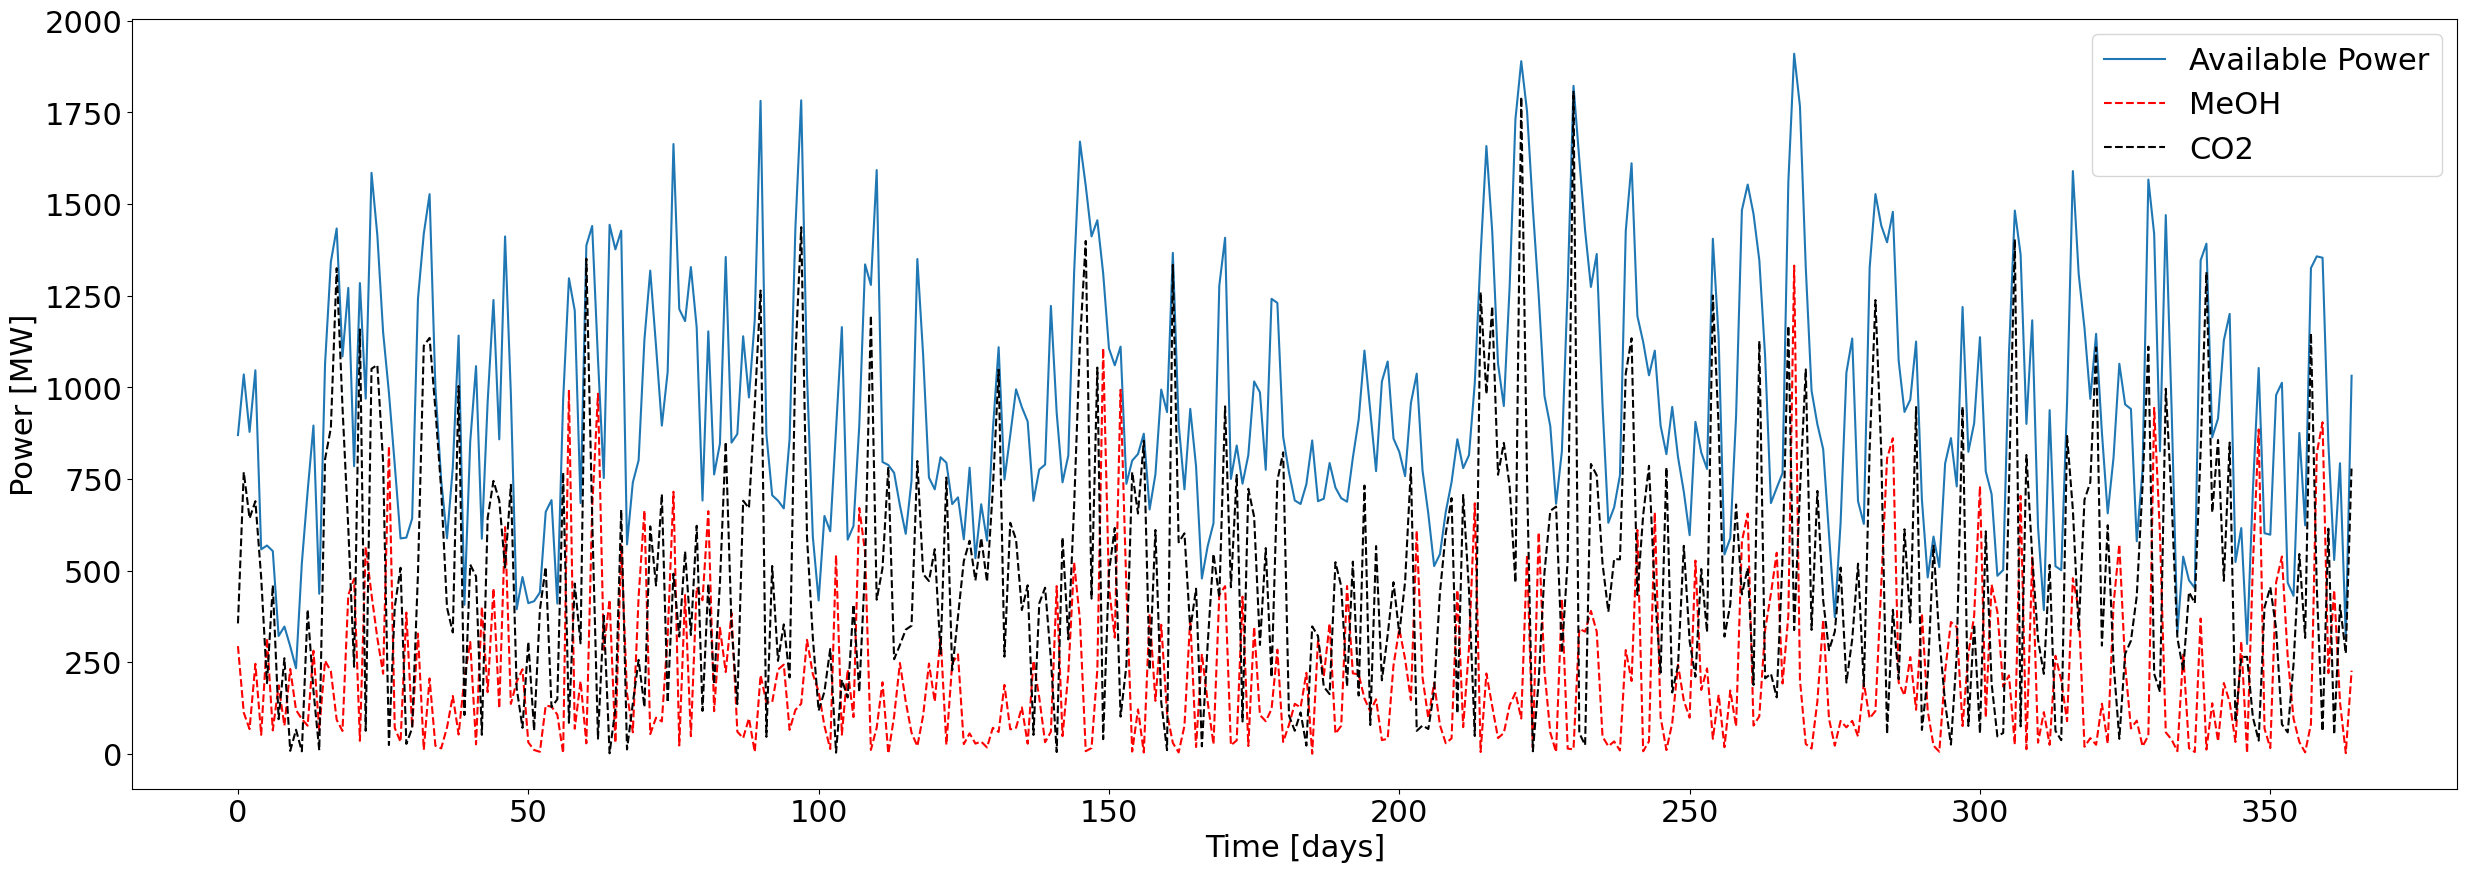

In [256]:
ts = time_steps
nrows = int(8760/365) #take average every n-rows
solar = groupedAvg(production_data_18['GR_solar_generation_actual'].fillna(0).to_numpy(),nrows)
wind = groupedAvg(production_data_18['GR_wind_onshore_generation_actual'].fillna(0).to_numpy(),nrows)
p_total = np.zeros(ts)
for i in range(ts):
    p_total[i] = solar[i]+wind[i]
t = np.arange(ts)
P_Co2 = res.x[0:ts]
P_MeOH = res.x[ts:2*ts]
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
plt.plot(t,p_total,label = 'Available Power')
plt.plot(t,P_MeOH,'--',color = 'red',label = 'MeOH')
plt.plot(t,P_Co2,'--',color = 'black',label ='CO2')
plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Power [MW]')
plt.show